In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Test №1

Описание данных:

* userID: уникальный идентификатор пользователя

* browser: браузер, который использовал userID

* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)

* n_clicks: количество кликов, которые пользоваль совершил за n_queries

* n_queries: количество запросов, который совершил userID, пользуясь браузером browser

* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [2]:
data = pd.read_csv('ab_browser_test.csv')

In [3]:
data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


In [4]:
exp_data = data[data['slot'] == 'exp']
control_data = data[data['slot'] == 'control']

In [5]:
round((exp_data.n_clicks.sum() - control_data.n_clicks.sum()) / control_data.n_clicks.sum() * 100, 3)

1.614

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
np.random.seed(0)
n_boot_samples = 500

exp_median_scores = list(map(np.median, get_bootstrap_samples(exp_data.n_clicks.values, n_boot_samples)))
control_median_scores = list(map(np.median, get_bootstrap_samples(control_data.n_clicks.values, n_boot_samples)))

print("95% confidence interval for exp median:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for control median:",  stat_intervals(control_median_scores, 0.05))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for exp median: [5. 5.]
95% confidence interval for control median: [4. 4.]
95% confidence interval for the difference between medians [-1. -1.]


In [8]:
np.random.seed(0)

exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_data.n_clicks.values, n_boot_samples)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control_data.n_clicks.values, n_boot_samples)))

print("95% confidence interval for exp mean:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for control mean:",  stat_intervals(control_mean_scores, 0.05))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores)))
print("95% confidence interval for the difference between means",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for exp mean: [11.50789349 11.6588664 ]
95% confidence interval for control mean: [11.20668696 11.35347509]
95% confidence interval for the difference between means [-0.40496719 -0.19960335]


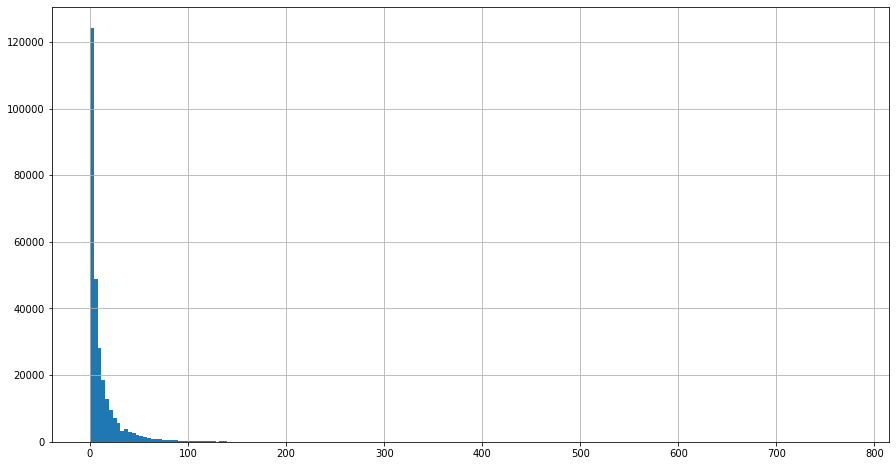

In [9]:
pylab.figure(figsize=(15,8))
pylab.grid()
pylab.hist(exp_data.n_clicks, bins=200)
pylab.show()

In [10]:
mean = np.array(control_mean_scores).mean()
control_boot_chi_squared = ((control_mean_scores - mean)**2).sum()
print('mean = %f, control_boot_chi_squared = %f' % (mean, control_boot_chi_squared))

mean = 11.280320, control_boot_chi_squared = 0.724024


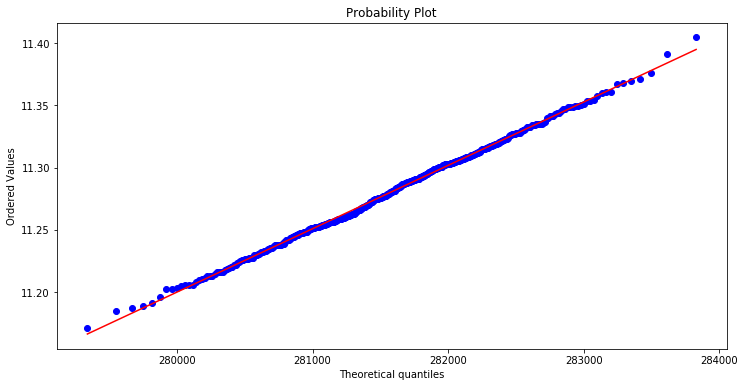

Rˆ2 = 0.998389


In [11]:
pylab.figure(figsize=(12,6))
_, info =stats.probplot(control_mean_scores, dist="chi2", 
                              sparams=281579, plot=plt)
pylab.show()
print('Rˆ2 = %f' % info[2]**2)

In [12]:
np.random.seed(0)

control_boot_chi_squared = list(map(np.std, get_bootstrap_samples(control_data.n_clicks.values, n_boot_samples)))
print("95% confidence interval for control std:",  stat_intervals(control_boot_chi_squared, 0.05))

95% confidence interval for control std: [19.97981291 20.63262605]


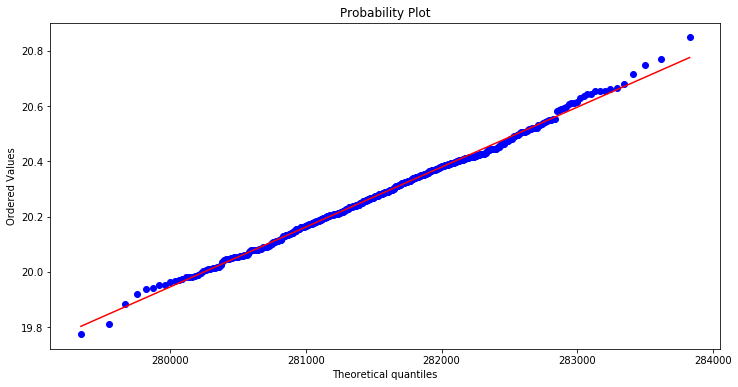

Rˆ2 = 0.996839


In [13]:
pylab.figure(figsize=(12,6))
_, info =stats.probplot(control_boot_chi_squared, dist="chi2", 
                              sparams=281579, plot=plt)
pylab.show()
print('Rˆ2 = %f' % info[2]**2)

In [14]:
stats.mannwhitneyu(pd.pivot_table(exp_data,index=['userID'], values=['n_clicks'], aggfunc='sum').n_clicks.values,
                   pd.pivot_table(control_data ,index=['userID'], values=['n_clicks'], aggfunc='sum').n_clicks.values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [15]:
num_arr = [2, 4, 14, 17, 20, 22]
p_val = np.array([])
for num in num_arr:
    _, p = stats.mannwhitneyu(exp_data[exp_data['browser'] == 'Browser #'+str(num)].n_clicks.values,
                              control_data[control_data['browser'] == 'Browser #'+str(num)].n_clicks.values)
    p_val = np.append(p_val, p)
p_val

array([0.02724386, 0.40760618, 0.        , 0.0374006 , 0.45366656,
       0.25740552])

In [16]:
reject, p_corrected, a1, a2 = multipletests(p_val, 
                                            alpha = 0.05, 
                                            method = 'holm')

In [17]:
d = pd.DataFrame(p_val, columns=['p-value'])
d['reject'] = reject
d['p_corrected'] = p_corrected
d

,p-value,reject,p_corrected
0,0.027244,False,0.136219
1,0.407606,False,0.815212
2,0.000000,True,0.000000
3,0.037401,False,0.149602
4,0.453667,False,0.815212
5,0.257406,False,0.772217


In [18]:
exp_prop = pd.pivot_table(exp_data,index=['browser'],
                          values=['n_queries', 'n_nonclk_queries'],
                          aggfunc='sum')
control_prop = pd.pivot_table(control_data,index=['browser'],
                              values=['n_queries', 'n_nonclk_queries'],
                              aggfunc='sum')
exp_prop['proportion'] = 100 * exp_prop.n_nonclk_queries / exp_prop.n_queries
control_prop['proportion'] = 100 * control_prop.n_nonclk_queries / control_prop.n_queries
print('exp_prop \n',exp_prop)
print()
print('control_prop \n', control_prop)

exp_prop 
              n_nonclk_queries  n_queries  proportion
browser                                             
Browser #14            123656     282606   43.755617
Browser #17             77614     210123   36.937413
Browser #2             246514     548019   44.982747
Browser #20             72998     187283   38.977376
Browser #22            296177     743156   39.853947
Browser #4             456508    1011250   45.142942

control_prop 
              n_nonclk_queries  n_queries  proportion
browser                                             
Browser #14            161252     279998   57.590411
Browser #17             75837     208921   36.299367
Browser #2             260259     566239   45.962747
Browser #20             78548     193752   40.540485
Browser #22            315470     777135   40.593977
Browser #4             498254    1060771   46.970930


# Test №2

In [19]:
import itertools
from scipy.stats import chi2_contingency

Измерены следующие признаки:

* state — штат США
* account_length — длительность использования аккаунта
* area_code — деление пользователей на псевдорегионы, использующееся в телекоме
* intl_plan — подключена ли у пользователя услуга международного общения
* vmail_plan — подключена ли у пользователя услуга голосовых сообщений
* vmail_message — количество голосых сообщений, который пользователь отправил / принял
* day_calls — сколько пользователь совершил дневных звонков
* day_mins — сколько пользователь проговорил минут в течение дня
* day_charge — сколько пользователь заплатил за свою дневную активность
* eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности
* night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности
* intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения
* custserv_calls — сколько раз пользователь позвонил в службу поддержки
* treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)
* mes_estim — оценка интенсивности пользования интернет мессенджерами
* churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [20]:
data = pd.read_csv('churn_analysis.csv')
data

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3328,AZ,192,415,no,yes,36,156.2,77,26.55,...,279.1,83,12.56,9.9,6,2.67,2,2,0.59,False.
3329,3329,WV,68,415,no,no,0,231.1,57,39.29,...,191.3,123,8.61,9.6,4,2.59,3,2,0.32,False.
3330,3330,RI,28,510,no,no,0,180.8,109,30.74,...,191.9,91,8.64,14.1,6,3.81,2,1,0.47,False.
3331,3331,CT,184,510,yes,no,0,213.8,105,36.35,...,139.2,137,6.26,5.0,10,1.35,2,2,0.32,False.


In [21]:
control_data = data[data['treatment'] == 1]

In [22]:
control_data.state.unique()

array(['KS', 'OH', 'LA', 'IA', 'VT', 'CO', 'WY', 'MO', 'GA', 'AK', 'MA',
       'NJ', 'AR', 'MI', 'IN', 'MN', 'SD', 'TX', 'DC', 'NY', 'OR', 'AZ',
       'MS', 'UT', 'ME', 'ID', 'FL', 'NV', 'WA', 'WV', 'NH', 'VA', 'NM',
       'KY', 'MT', 'PA', 'RI', 'DE', 'OK', 'NE', 'CT', 'WI', 'CA', 'NC',
       'MD', 'TN', 'AL', 'IL', 'ND', 'HI', 'SC'], dtype=object)

In [23]:
corr_table = pd.crosstab(control_data['state'],control_data['churn'])
corr_table.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [24]:
p_val_1 = []
for i, j in itertools.combinations(control_data.state.unique(), 2):
    _, p, _, _ = stats.chi2_contingency(corr_table.loc[[i, j]], correction=False)
    p_val_1.append(p)

counter = 0
for p in p_val_1:
    if p < 0.05:
        counter += 1
counter

34

In [25]:
_, p, _, _ = stats.chi2_contingency(corr_table, correction=False)
print('p-value = %f' % p)

p-value = 0.709759


In [26]:
p_val_2 = []
for i, j in itertools.combinations(control_data.state.unique(), 2):
    _, p, _, _ = stats.chi2_contingency(corr_table.loc[[i, j]], correction=True)
    p_val_2.append(p)
    
counter = 0
for p in p_val_2:
    if p < 0.05:
        counter += 1
counter

0

In [27]:
p_val_3 = []
for i, j in itertools.combinations(control_data.state.unique(), 2):
    _, p, = stats.fisher_exact(corr_table.loc[[i, j]])
    p_val_3.append(p)

counter = 0
for p in p_val_3:
    if p < 0.05:
        counter += 1
counter

10

In [28]:
pd.DataFrame(np.array([p_val_1, p_val_2, p_val_3]).T, columns=['p_val_1', 'p_val_2', 'p_val_3'])

,p_val_1,p_val_2,p_val_3
0,0.075524,0.159054,0.138333
1,0.024052,0.067770,0.032840
2,0.282190,0.493752,0.440083
3,0.616769,0.867518,0.743389
4,0.679125,0.937468,0.747108
...,...,...,...
1270,0.952933,0.497280,1.000000
1271,0.267505,0.522363,0.379171
1272,0.652998,0.916450,1.000000
1273,0.322191,0.549046,0.442704


In [29]:
stats.pearsonr(data['day_calls'],data['mes_estim'])

(-0.051794350587572625, 0.0027798836869738384)

In [30]:
stats.spearmanr(data['day_calls'],data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

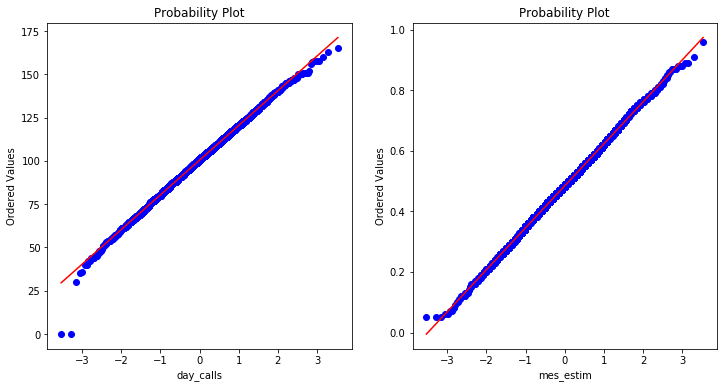

In [31]:
pylab.figure(figsize=(12,6))

pylab.subplot(1,2,1)
stats.probplot(data['day_calls'], plot=plt)
pylab.xlabel("day_calls")

pylab.subplot(1,2,2)
stats.probplot(data['mes_estim'], plot=plt)
pylab.xlabel("mes_estim")

pylab.show()

In [32]:
chi2, p, _, _ = chi2_contingency(corr_table)
n = corr_table.values.sum()
r,k = corr_table.shape
print('coef V Kramer = %f' %np.sqrt(chi2 / (n * min(r - 1, k - 1))))
print('p-value = %f' %p)

coef V Kramer = 0.200393
p-value = 0.709759


In [33]:
data_0 = data[data['treatment'] == 0]
data_2 = data[data['treatment'] == 2]

In [108]:
stats.ttest_ind(data_0.drop(columns=['Unnamed: 0','state','intl_plan', 'vmail_plan', 'treatment', 'churn']),
                data_2.drop(columns=['Unnamed: 0','state','intl_plan', 'vmail_plan', 'treatment', 'churn']),
                equal_var = False)

Ttest_indResult(statistic=array([-2.48382401, -1.66635624, -0.95003277,  2.47729877, -0.36603865,
        2.47745975,  0.287776  ,  1.16935366,  0.28717771,  2.39008631,
       -1.58756706,  2.38906129,  0.91737434,  0.03190939,  0.91827464,
       -0.66616906,  1.59575026]), pvalue=array([0.01307131, 0.0957833 , 0.3421984 , 0.01331158, 0.71437119,
       0.0133056 , 0.77354493, 0.24238627, 0.77400291, 0.01692709,
       0.11252644, 0.01697427, 0.35904554, 0.97454717, 0.35857423,
       0.50537225, 0.11068603]))

In [121]:
data_0['churn_corrected'] = [1 if t == 'True.' else 0 for t in data_0.churn.values]
data_2['churn_corrected'] = [1 if t == 'True.' else 0 for t in data_2.churn.values]
control_data['churn_corrected'] = [1 if t == 'True.' else 0 for t in control_data.churn.values]

/Users/mate/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mate/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mate/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [124]:
_, p_02 = stats.ttest_ind(data_0.churn_corrected, data_2.churn_corrected, equal_var = False)
_, p_10 = stats.ttest_ind(data_0.churn_corrected, control_data.churn_corrected, equal_var = False)
_, p_12 = stats.ttest_ind(data_2.churn_corrected, control_data.churn_corrected, equal_var = False)

print('p_02 = %f' % p_02) 
print('p_10 = %f' % p_10) 
print('p_12 = %f' % p_12)

p_02 = 0.156208
p_10 = 0.228883
p_12 = 0.009356


In [127]:
reject, p_corrected, a1, a2 = multipletests([p_02, p_10, p_12], 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [135]:
pd.DataFrame(np.array([[p_02, p_10, p_12], p_corrected]),
             columns=['p_02','p_10','p_12'],
             index=['p-value befor correction', 'p-value after correction'])

,p_02,p_10,p_12
p-value befor correction,0.156208,0.228883,0.009356
p-value after correction,0.312416,0.312416,0.028069
